In [1]:
from dnadb import fasta, taxonomy
from IPython.display import clear_output
import lightning as L
from matplotlib import colormaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
max_sequence_length = 250
embed_dim = 256
num_heads = 8
stack = 8
kmer = 3
kmer_stride = 1

In [3]:
from torch.utils.checkpoint import checkpoint

class SampleEncoder(L.LightningModule):
    def __init__(self, dna_encoder: nn.Module, embed_dim: int, stack: int, num_heads: int, chunk_size: int = 256):
        super().__init__()
        self.dna_encoder = dna_encoder
        self.embed_dim = embed_dim
        self.stack = stack
        self.num_heads = num_heads
        self.chunk_size = chunk_size
        self.transformers = layers.TransformerEncoder(
            layers.TransformerEncoderBlock(
                layers.MultiHeadAttention(
                    embed_dim=self.embed_dim,
                    num_heads=self.num_heads
                ),
                feedforward_dim=self.embed_dim
            ),
            num_layers=self.stack
        )
        self.class_token = nn.Parameter(torch.randn(self.embed_dim))

    def forward(self, inputs, attention_head_mask = None, return_attention_weights = False):
        if not torch.is_floating_point(inputs):
            sequence_embeddings = []
            inputs_flat = inputs.flatten(0, -2)
            for i in range(0, inputs_flat.shape[0], self.chunk_size):
                sequence_embeddings.append(
                    checkpoint(
                        self.dna_encoder,
                        inputs_flat[i:i+self.chunk_size],
                        use_reentrant=False
                    )[0]
                )
            sequence_embeddings = torch.concat(sequence_embeddings, 0).unflatten(0, inputs.shape[:-1])
        else:
            sequence_embeddings = inputs
        class_tokens = self.class_token.expand(*inputs.shape[:-2], 1, -1)
        out = torch.cat((class_tokens, sequence_embeddings), -2)
        out, attention_weights = self.transformers(
            out,
            attention_head_mask=attention_head_mask,
            average_attention_weights=False,
            return_attention_weights=True)

        class_tokens = out.select(-2, 0)
        sequence_embeddings = out.narrow(-2, 1, out.shape[-2] - 1)

        if return_attention_weights:
            return class_tokens, attention_weights
        return class_tokens

class GcmsEncoder(L.LightningModule):
    def __init__(self, patch_size: int, embed_dim: int, stack: int, num_heads: int):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.stack = stack
        self.num_heads = num_heads

        self.class_token = nn.Parameter(torch.randn(size=(1, 1, self.embed_dim)))

        self.retention_conv = nn.Conv1d(
            self.embed_dim,
            self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size)
        self.signal_conv = nn.Conv1d(
            1,
            self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size)

        self.transformers = layers.TransformerEncoder(
            layers.TransformerEncoderBlock(
                layers.MultiHeadAttention(
                    embed_dim=self.embed_dim,
                    num_heads=self.num_heads
                ),
                feedforward_dim=embed_dim
            ),
            num_layers=self.stack
        )

    def _retention_time_encoding(self, position):
        if self.embed_dim % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                             "odd dim (got dim={:d})".format(self.embed_dim))
        length = position.size(-1)
        pe = torch.zeros(position.size(0), length, self.embed_dim).to(position.device)
        position = position.unsqueeze(-1)
        div_term = torch.exp((torch.arange(0, self.embed_dim, 2, dtype=torch.float) *
                             -(np.log(10000.0) / self.embed_dim)))
        div_term = div_term.to(position.device)
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        pe[torch.where((position == 0.0).squeeze(-1))] = 0
        return pe

    def forward(
        self,
        retention_times: torch.FloatTensor,
        signals: torch.FloatTensor,
        mask = None,
        attention_head_mask = None,
        return_attention_weights = False
    ):
        retention_times = self._retention_time_encoding(retention_times)
        retention_times = self.retention_conv(retention_times.transpose(-1, -2)).transpose(-1, -2)
        signals = self.signal_conv(signals.unsqueeze(-1).transpose(-1, -2)).transpose(-1, -2)
        out = retention_times + signals

        if mask is not None:
            mask = mask.narrow(-1, 0, mask.shape[-1] // self.patch_size * self.patch_size)
            mask = F.pad(torch.any(mask.unflatten(-1, (-1, 20)), -1), (1, 0))

        # Prepend class tokens
        class_tokens = self.class_token.expand(*out.shape[:-2], 1, -1)
        out = torch.cat([class_tokens, out], dim=1)
        out, attention_weights = self.transformers(
            out,
            src_key_padding_mask=mask,
            attention_head_mask=attention_head_mask,
            average_attention_weights=False,
            return_attention_weights=True)

        class_tokens, tokens = out[:,0,:], out[:,1:,:]
        if return_attention_weights:
            return class_tokens, attention_weights
        return class_tokens

class SampleGcmsContrastiveTrainer(L.LightningModule):
    def __init__(self, sample_encoder: nn.Module, gcms_encoder: nn.Module, max_temp: float = 100.0):
        super().__init__()
        self.sample_encoder = sample_encoder
        self.gcms_encoder = gcms_encoder
        self.max_temp = max_temp
        self.w_a = nn.Linear(sample_encoder.embed_dim, sample_encoder.embed_dim, bias=False)
        self.w_b = self.w_a # shared projections
        # self.w_b = nn.Linear(sample_encoder.embed_dim, sample_encoder.embed_dim, bias=False)
        # self.t = nn.Parameter(torch.tensor(1.0))
        self.t = torch.tensor(0.0)

    def forward(self, x, y):
        a_f = self.sample_encoder(x)
        b_f = self.gcms_encoder(*y)
        a_e = F.normalize(a_f, p=2, dim=1)
        b_e = F.normalize(b_f, p=2, dim=1)
        logits = torch.tensordot(a_e, b_e.T, 1)
        return a_f, b_f, logits

    def _step(self, batch):
        x, y = batch
        labels = torch.arange(x.size(0)).to(self.device)
        a_f, b_f, logits = self(x, y)
        loss_a = F.cross_entropy(logits * torch.exp(self.t), labels)
        loss_b = F.cross_entropy(logits.T * torch.exp(self.t), labels)
        loss = (loss_a + loss_b) / 2
        loss = loss + F.mse_loss(a_f, b_f)
         accuracy = torch.sum(
            (torch.argmax(logits, dim=-1) == labels).int() + (torch.argmax(logits, dim=-2) == labels).int()
        ) / labels.shape[-1] / 2.0
        return loss, accuracy

    def training_step(self, batch, batch_index):
        loss, accuracy = self._step(batch)
        self.log("train/loss", loss, on_step=True, on_epoch=False)
        self.log("train/accuracy", accuracy, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_index):
        loss, accuracy = self._step(batch)
        self.log("validation/loss", loss, on_step=True, on_epoch=False)
        self.log("validation/accuracy", accuracy, on_step=True, on_epoch=False)
        return loss

    def on_train_batch_end(self, *args, **kwargs):
        self.t.data = torch.clamp(self.t, 0.0, self.max_temp)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [4]:
model = torch.load("./model.pt").eval()
sample_encoder = model.sample_encoder.cuda()
dna_encoder = sample_encoder.dna_encoder
gcms_encoder = model.gcms_encoder.cuda()

dna_encoder.requires_grad_(False)

DnaBertModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderBlock(
        (mab): MultiHeadAttentionBlock(
          (mha): RelativeMultiHeadAttention(
            (w_query): Linear(in_features=256, out_features=256, bias=True)
            (w_key): Linear(in_features=256, out_features=256, bias=True)
            (w_value): Linear(in_features=256, out_features=256, bias=True)
            (w_output): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (feedforward_linear1): Linear(in_features=256, out_features=256, bias=True)
          (feedforward_linear2): Linear(in_features=256, out_features=256, bias=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False

## Dataset & Processing

In [36]:
sequences = fasta.FastaDb("./SnakeExperiment2/sequences.fasta.db")
mappings = sequences.mappings("./SnakeExperiment2/sequences.fasta.mapping.db")

In [37]:
with open("./data/gcms.pkl", "rb") as f:
    gcms_samples = pickle.load(f)

In [38]:
gcms_groups = {}
for f in Path("./data").glob("**/*.mzML"):
    group = f.name.split('-')[0].lower()
    gcms_groups[group] = f

In [39]:
mappings_dict = {m.name.split('_')[0]: m for m in mappings}
metadata = pd.read_csv("./data/gcms/201210.disease.csv")
metadata = metadata[metadata["swab.origin"] == "snake"]
hts_samples = {}
for _, row in metadata.iterrows():
    group = row["exp.call"]
    if group not in gcms_samples or row["group"] not in mappings_dict:
        continue
    hts_samples[group] = mappings_dict[row["group"]]
len(hts_samples)

14

In [40]:
for k in set(gcms_samples.keys()) - set(hts_samples.keys()):
    del gcms_samples[k]
len(gcms_samples)

14

In [41]:
sample_names = list(hts_samples.keys())

## Evaluation

In [15]:
tokenizer = dna_encoder.tokenizer
vocabulary = dna_encoder.vocabulary
num_hts_subsamples = 10
sample_size = 1000
max_gcms_length = 20000
rng = np.random.default_rng()

In [16]:
def collate_gcms(sample_names):
    # Draw chromatograms
    retention_times = torch.zeros((len(sample_names), max_gcms_length))
    signals = torch.zeros((len(sample_names), max_gcms_length))
    mask = torch.ones_like(signals, dtype=torch.bool)
    for i, sample_name in enumerate(sample_names):
        retention_time, signal = torch.from_numpy(gcms_samples[sample_name]).T
        # Randomly trim
        trimmed_length = signal.size(0)
        signal = signal / torch.max(signal)
        # Insert into batch in random valid location
        retention_times[i, :trimmed_length] = retention_time
        signals[i, :trimmed_length] = signal
        mask[i, :trimmed_length] = False
    labels = torch.tensor([1.0 if name[0] == 'e' else 0.0 for name in sample_names])
    return (retention_times, signals, mask), labels

def collate_hts(sample_names):
    def process_entry(entry):
        sequence = entry.sequence
        length = min(max_sequence_length, len(sequence))
        offset = torch.randint(0, len(sequence) - length + 1, (1,)).item()
        token_ids = torch.full((max_sequence_length - kmer + 1,), vocabulary["[PAD]"])
        token_ids = torch.tensor(list(vocabulary(tokenizer(sequence[offset:offset+length].encode()))))
        return F.pad(token_ids, (0, (max_sequence_length - kmer + 1) - token_ids.shape[0]))
    samples = [hts_samples[name].sample(sample_size, rng) for name in sample_names]
    sequence_ids = [[x.identifier for x in sample] for sample in samples]
    sequences = torch.stack([torch.stack([process_entry(x) for x in sample]) for sample in samples])
    labels = torch.tensor([1.0 if name[0] == 'e' else 0.0 for name in sample_names])
    return sequence_ids, sequences, labels

In [55]:
max_gcms_length = 20000
gcms_embeddings = {}
with torch.no_grad():
    for sample_name in tqdm(sample_names):
        x = collate_gcms([sample_name])[0]
        y = gcms_encoder(x[0].cuda(), x[1].cuda(), x[2].cuda())[0].detach().to("cpu")
        gcms_embeddings[sample_name] = y
        # x = torch.from_numpy(gcms_samples[sample_name].astype(np.float32))
        # if max_chromatogram_length is not None:
        #     offset = rng.integers(0, len(x) - max_chromatogram_length + 1)
        #     x = x[offset:offset+max_chromatogram_length]
        # y = gcms_encoder(x.to(gcms_encoder.device)[None,:,:]).detach().to("cpu")
        # gcms_embeddings[sample_name] = y[0]

100%|██████████| 14/14 [00:00<00:00, 88.41it/s]


In [81]:
max_sequence_length = 250
kmer = dna_encoder.kmer
hts_embeddings = {}
with torch.no_grad():
    for sample_name in tqdm(sample_names):
        sequences = collate_hts([sample_name]*num_hts_subsamples)[1]
        if sample_name not in hts_embeddings:
            hts_embeddings[sample_name] = []
        for x in sequences:
            y = sample_encoder(x.to(sample_encoder.device)).detach().to("cpu")
            hts_embeddings[sample_name].append(y)
        hts_embeddings[sample_name] = torch.stack(hts_embeddings[sample_name])

100%|██████████| 14/14 [01:24<00:00,  6.06s/it]


In [57]:
embeddings = []
with torch.no_grad():
    for sample_name in hts_embeddings:
        embeddings += list(hts_embeddings[sample_name])
    for sample_name in gcms_embeddings:
        embeddings.append(gcms_embeddings[sample_name])
embeddings = torch.stack(embeddings)
embeddings.shape

torch.Size([154, 256])

In [70]:
# dist = cdist(embeddings, embeddings)
# mds = MDS(dissimilarity="precomputed", metric=True)
# points = mds.fit_transform(dist)
tsne = TSNE()
points = tsne.fit_transform(embeddings)

In [73]:
hts_points = points[:len(hts_embeddings)*num_hts_subsamples].reshape((len(hts_embeddings), num_hts_subsamples, -1))
gcms_points = points[len(hts_embeddings)*num_hts_subsamples:]
hts_points.shape, gcms_points.shape

((14, 10, 2), (14, 2))

Text(0.5, 1.0, 't-SNE Plot of HTS & GCMS Embeddings')

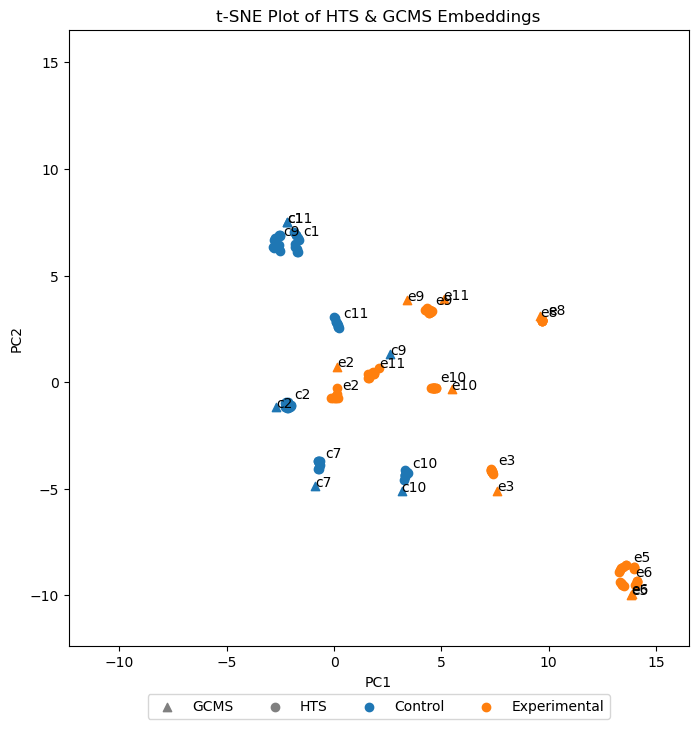

In [75]:
cmap = colormaps["tab10"]

axis_min = min(np.min(hts_points), np.min(gcms_points))
axis_max = max(np.max(hts_points), np.max(gcms_points))
pad = (axis_max - axis_min) * 0.1
axis_min -= pad
axis_max += pad

plt.figure(figsize=(8, 8))
plt.xlim((axis_min, axis_max))
plt.ylim((axis_min, axis_max))

for i, sample_name in enumerate(sample_names):
    x, y = gcms_points[i]
    plt.text(x - 0.01, y - 0.01, sample_name)
    plt.scatter(x, y, marker="^", color=cmap(sample_name.startswith("e")))

for i, sample_name in enumerate(sample_names):
    x, y = hts_points[i].T
    plt.scatter(x, y, color=cmap(sample_name.startswith("e")))
    plt.text(np.mean(x) + 0.3, np.mean(y) + 0.3, sample_name)

plt.scatter([], [], label="GCMS", marker="^", color="gray")
plt.scatter([], [], label="HTS", color="gray")
plt.scatter([], [], label="Control", color=cmap(0))
plt.scatter([], [], label="Experimental", color=cmap(1))

plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.13))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("t-SNE Plot of HTS & GCMS Embeddings")

## Attribution

In [17]:
class DiseaseClassifier(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.out = nn.Linear(embed_dim, 1)

    def forward(self, *args, return_attention_weights: bool = False, **kwargs):
        y, attention_weights = self.model(*args, return_attention_weights=True, **kwargs)
        y = F.sigmoid(self.out(y).squeeze(-1))
        if return_attention_weights:
            return y, attention_weights
        return y

    def training_step(self, batch):
        x, y_true = batch
        y_pred = self(*x) if isinstance(x, tuple) else self(x)
        loss = F.binary_cross_entropy(y_pred, y_true)
        self.log("train/loss", loss, on_epoch=True, on_step=False)
        self.log("train/accuracy", torch.sum((y_pred >= 0.5) == y_true) / y_true.numel(), on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), 1e-3)

In [18]:
hts_loader = torch.utils.data.DataLoader(sample_names, batch_size=1, collate_fn=collate_hts)
gcms_loader = torch.utils.data.DataLoader(sample_names, batch_size=1, collate_fn=collate_gcms)

In [19]:
sample_classifier = DiseaseClassifier(sample_encoder)
gcms_classifier = DiseaseClassifier(gcms_encoder)

In [16]:
sample_classifier.model.requires_grad_(False)
logger = L.pytorch.loggers.csv_logs.CSVLogger("./logs", "sample_regression")
trainer = L.Trainer(
    max_epochs=10,
    callbacks=[
        L.pytorch.callbacks.RichProgressBar(refresh_rate=10)
    ],
    logger=logger,
    accumulate_grad_batches=5
)
trainer.fit(sample_classifier, hts_loader)

Epoch 9/9  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 0:00:05 • 0:00:00 2.19it/s v_num: 9.000

`Trainer.fit` stopped: `max_epochs=10` reached.


In [113]:
num_hts_subsamples = 10
sample_classifier.requires_grad_(True).cuda().eval()
hts_attribution_scores = {}
hts_sequence_ids = {}
for sample_name in tqdm(sample_names*num_hts_subsamples):
    cls = sample_name[0]
    sequence_ids, sample, label = collate_hts([sample_name])
    if sample_name not in hts_sequence_ids:
        hts_sequence_ids[sample_name] = []
    hts_sequence_ids[sample_name].append(sequence_ids)
    with torch.no_grad():
        sample = sample_encoder.dna_encoder(sample.cuda())[0]
    attention_mask = torch.ones((len(sample_encoder.transformers), sample_encoder.transformers.layers[0].mab.mha.num_heads), device=sample_encoder.device)
    scores = []
    for layer_i, transformer in enumerate(sample_encoder.transformers.layers):
        layer_grads = []
        for head_i in tqdm(range(sample_encoder.transformers.layers[0].mab.mha.num_heads), leave=False):
            head_grads = None
            for m in torch.linspace(0.0, 1.0, 20):
                attention_mask[layer_i][head_i] = m
                y, att_weights = sample_classifier(sample, return_attention_weights=True, attention_head_mask=attention_mask)
                loss = F.binary_cross_entropy(y, label.to(y.device))
                grads = torch.autograd.grad(loss, att_weights[layer_i])[0].detach()
                sample_classifier.zero_grad(set_to_none=True)
                with torch.no_grad():
                    grads = grads[0][head_i]
                    if head_grads is None:
                        head_grads = grads.to("cpu")
                    else:
                        head_grads = head_grads + grads.to("cpu")
            with torch.no_grad():
                layer_grads.append(att_weights[layer_i][0][head_i].cpu()*head_grads/20)
        scores.append(torch.stack(layer_grads))
    if sample_name not in hts_attribution_scores:
        hts_attribution_scores[sample_name] = []
    hts_attribution_scores[sample_name].append(torch.stack(scores))
    clear_output()

100%|██████████| 140/140 [38:25<00:00, 16.47s/it]


In [128]:
for sample_name in hts_attribution_scores:
    hts_attribution_scores[sample_name] = torch.stack([*hts_attribution_scores[sample_name]])

In [116]:
# with open("./logs/sequences.pkl", "wb") as f:
#     pickle.dump(hts_sequence_ids, f)

with open("./logs/taxonomies.pkl", "rb") as f:
    sample_taxonomies = pickle.load(f)

In [373]:
depth = 6

sequence_attribution_results = {
    "c": {},
    "e": {}
}
for sample_name in hts_sequence_ids:
    result = sequence_attribution_results[sample_name[0]]
    for i in range(len(hts_sequence_ids[sample_name])):
        scores = hts_attribution_scores[sample_name][i].sum(1).sum(0).sum(0)[1:]
        for sequence_id, score in zip(hts_sequence_ids[sample_name][i][0], scores):
            if sequence_id not in sample_taxonomies[sample_name][i]:
                tax = ("Unassigned",)*depth
            else:
                tax = sample_taxonomies[sample_name][i][sequence_id][0]
                tax = taxonomy.split_taxonomy(tax.taxonomy_label) if tax is not None else ("Unassigned",)
                tax += (depth-len(tax))*("Unassigned",)
            tax = tax[:depth]
            if tax[-1] == "Unassigned":
                tax = ("Unassigned",)*depth
            if tax not in result:
                result[tax] = {
                    "abundance": 0,
                    "score": 0.0
                }
            result[tax]["abundance"] += 1
            result[tax]["score"] += score

# Normalize everything by total score/abundance
for k, v in sequence_attribution_results.items():
    total_abundance = 0
    total_score = 0
    for stats in v.values():
        total_abundance += stats["abundance"]
        total_score += max(stats["score"], 0.0) #/ stats["abundance"]
    for stats in v.values():
        stats["score"] = stats["score"] / total_score #/ stats["abundance"]
        stats["abundance"] = stats["abundance"] / total_abundance

# Ensure dictionaries are sorted by highest scoring taxa first
for k, v in sequence_attribution_results.items():
    sequence_attribution_results[k] = dict(sorted(v.items(), key=lambda x: -x[1]["score"]))

Text(0.5, 0, 'Number of Taxa')

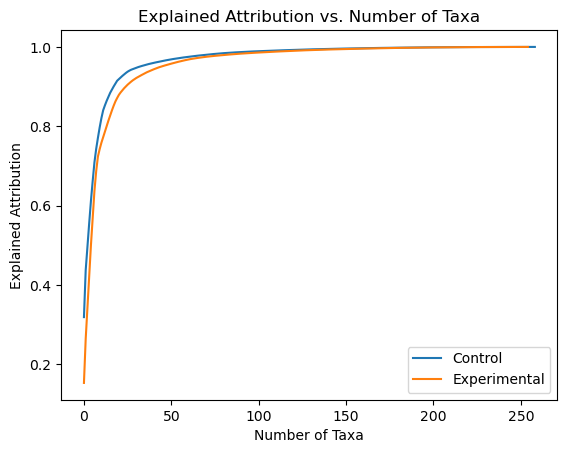

In [374]:
for cls, v in sequence_attribution_results.items():
    stats = [x["score"] for x in v.values() if x["score"] >= 0]
    plt.plot(np.cumsum(stats), label=labels[cls])
plt.legend()
plt.title("Explained Attribution vs. Number of Taxa")
plt.ylabel("Explained Attribution")
plt.xlabel("Number of Taxa")

Text(0.5, 0, 'Number of Taxa')

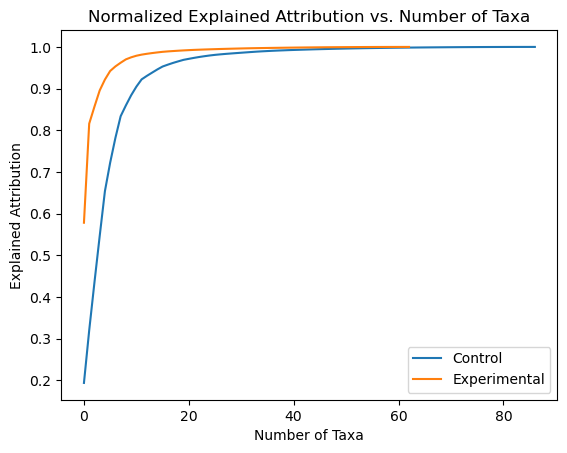

In [305]:
for cls, v in sequence_attribution_results.items():
    stats = [x["score"] for x in v.values() if x["score"] >= 0]
    plt.plot(np.cumsum(stats), label=labels[cls])
plt.legend()
plt.title("Normalized Explained Attribution vs. Number of Taxa")
plt.ylabel("Explained Attribution")
plt.xlabel("Number of Taxa")

In [375]:
min_threshold = 0.9
top_per_class = {}
for cls, v in sequence_attribution_results.items():
    top_per_class[cls] = []
    explained = 0.0
    for x in v.items():
        top_per_class[cls].append(x[0])
        explained += x[1]["score"]
        if explained >= min_threshold:
            break

In [376]:
labels = {"c": "Control", "e": "Experimental"}

In [377]:
top_taxa = set()
for v in top_per_class.values():
    top_taxa.update(v)
len(top_taxa)

41

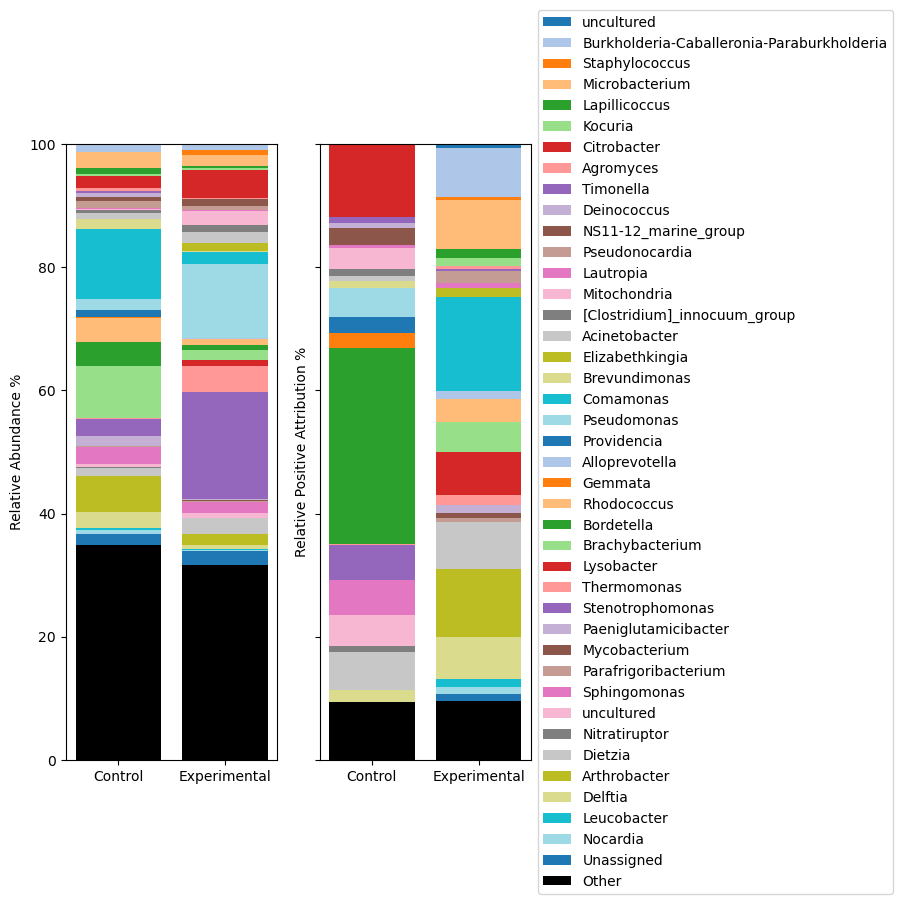

In [378]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Relative abundance
bottoms = 100.0*np.ones(len(top_per_class))
for i, tax in enumerate(top_taxa):
    tops = bottoms.copy()
    for j, (cls, stats) in enumerate(sequence_attribution_results.items()):
        if tax not in stats:
            continue
        bottoms[j] -= 100.0*stats[tax]["abundance"]
    ax1.bar([labels[x] for x in top_per_class], tops-bottoms, bottom=bottoms, color=colormaps["tab20"](i%20))
ax1.bar([labels[x] for x in top_per_class], bottoms, color="black", label="Other")
ax1.set_ylabel("Relative Abundance %")
ax1.set_ylim((0, 100))

# Relative attribution
bottoms = 100.0*np.ones(len(top_per_class))
for i, tax in enumerate(top_taxa):
    tops = bottoms.copy()
    for j, (cls, stats) in enumerate(sequence_attribution_results.items()):
        if tax not in stats or stats[tax]["score"] < 0:
            continue
        bottoms[j] -= 100.0*stats[tax]["score"]
    ax2.bar([labels[x] for x in top_per_class], tops-bottoms, bottom=bottoms, color=colormaps["tab20"](i%20), label=tax[-1])
ax2.bar([labels[x] for x in top_per_class], bottoms, color="black", label="Other")
ax2.set_ylabel("Relative Positive Attribution %")
ax2.set_ylim((0, 100))
ax2.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

In [20]:
gcms_classifier.model.requires_grad_(False)
logger = L.pytorch.loggers.csv_logs.CSVLogger("./logs", "gcms_regression")
trainer = L.Trainer(
    max_epochs=20,
    callbacks=[
        L.pytorch.callbacks.RichProgressBar(refresh_rate=10)
    ],
    logger=logger,
    accumulate_grad_batches=5
)
trainer.fit(gcms_classifier, gcms_loader)

Epoch 19/19 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 0:00:00 • 0:00:00 53.53it/s v_num: 9.000

`Trainer.fit` stopped: `max_epochs=20` reached.


In [21]:
gcms_classifier.requires_grad_(True).cuda().eval()
gcms_attribution_scores = {}
for sample_name in tqdm(sample_names):
    cls = sample_name[0]
    (retention_time, signal, mask), label = collate_gcms([sample_name])
    retention_time = retention_time.cuda()
    signal = signal.cuda()
    mask = mask.cuda()
    attention_mask = torch.ones((len(gcms_encoder.transformers), gcms_encoder.transformers.layers[0].mab.mha.num_heads), device=gcms_encoder.device)
    scores = []
    for layer_i, transformer in enumerate(gcms_encoder.transformers.layers):
        layer_grads = []
        for head_i in tqdm(range(gcms_encoder.transformers.layers[0].mab.mha.num_heads), leave=False):
            head_grads = None
            for m in torch.linspace(0.0, 1.0, 20):
                attention_mask[layer_i][head_i] = m
                y, att_weights = gcms_classifier(retention_time, signal, mask, return_attention_weights=True, attention_head_mask=attention_mask)
                loss = F.binary_cross_entropy(y, label.to(y.device))
                grads = torch.autograd.grad(loss, att_weights[layer_i])[0].detach()
                gcms_classifier.zero_grad(set_to_none=True)
                with torch.no_grad():
                    grads = grads[0][head_i]
                    if head_grads is None:
                        head_grads = grads.to("cpu")
                    else:
                        head_grads = head_grads + grads.to("cpu")
            with torch.no_grad():
                layer_grads.append(att_weights[layer_i][0][head_i].cpu()*head_grads/20)
        scores.append(torch.stack(layer_grads))
    gcms_attribution_scores[sample_name] = torch.stack(scores)
    clear_output()

100%|██████████| 14/14 [05:21<00:00, 22.94s/it]


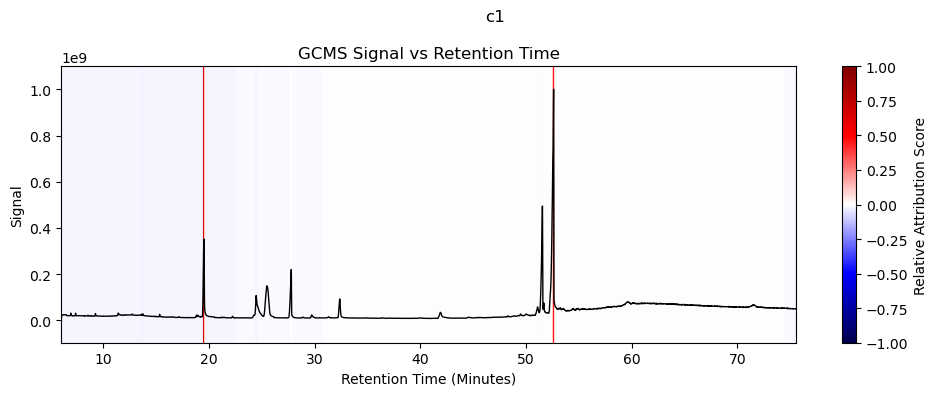

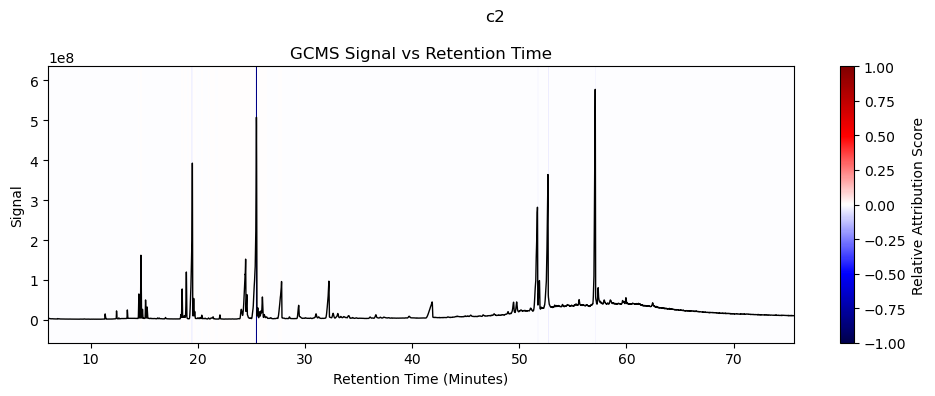

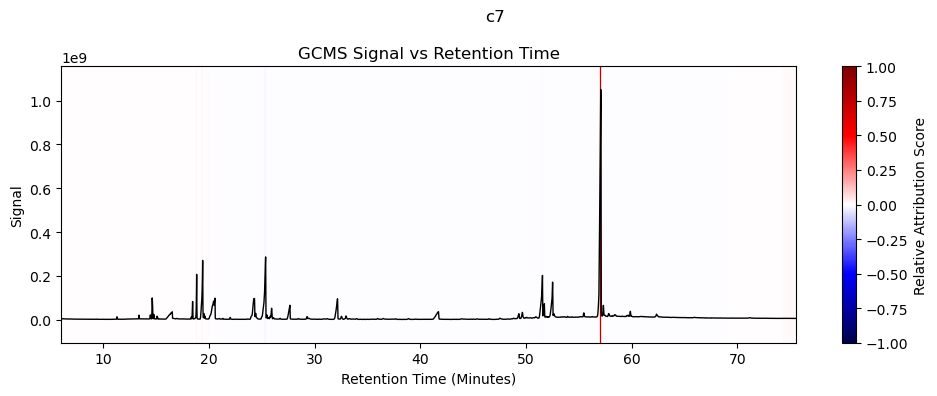

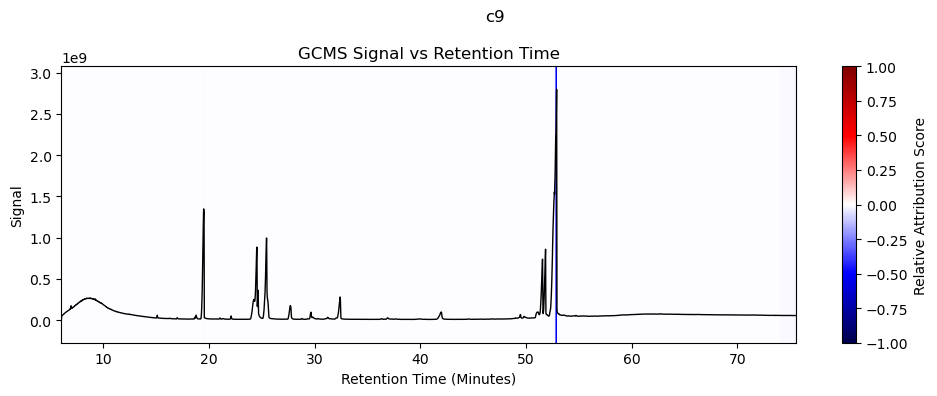

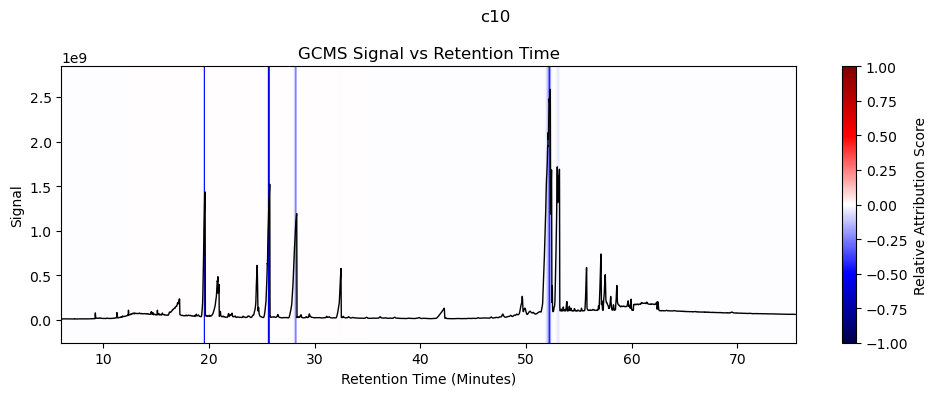

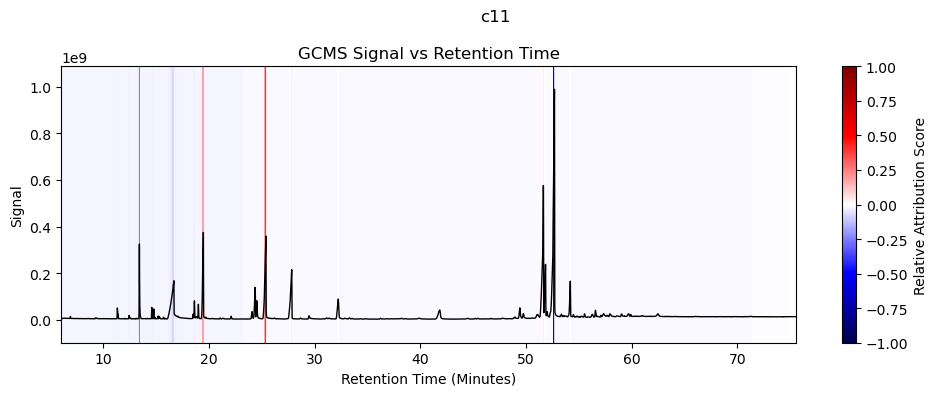

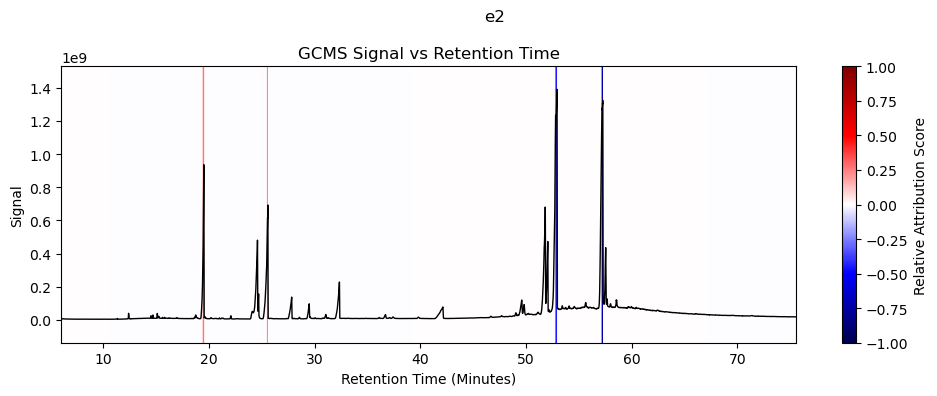

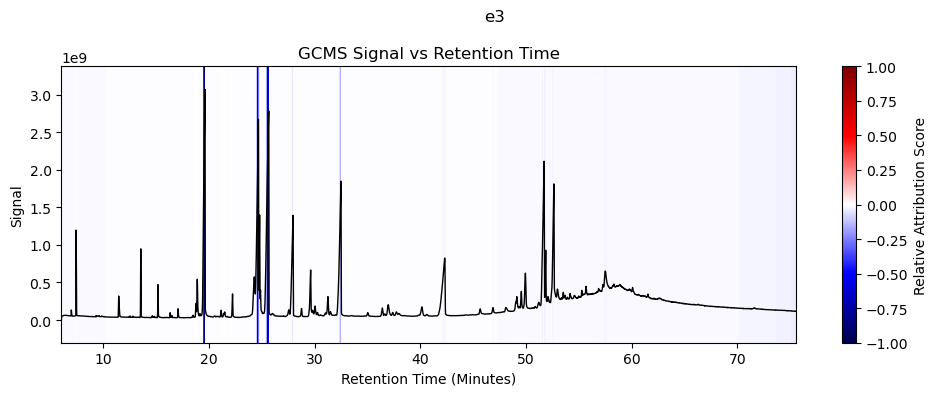

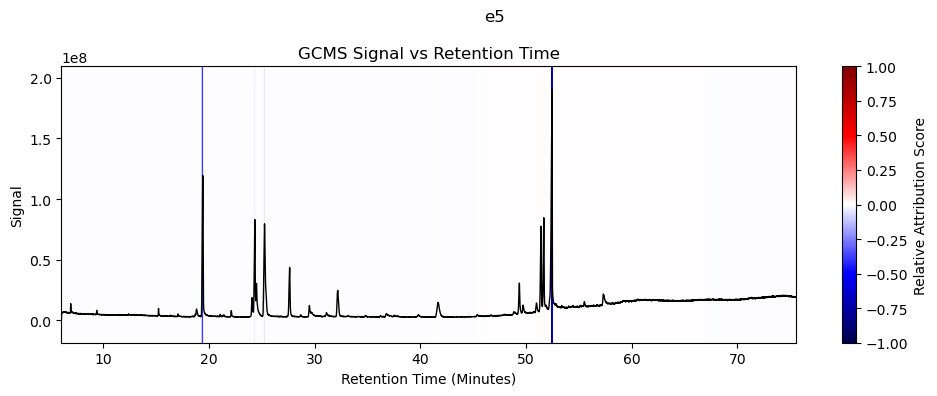

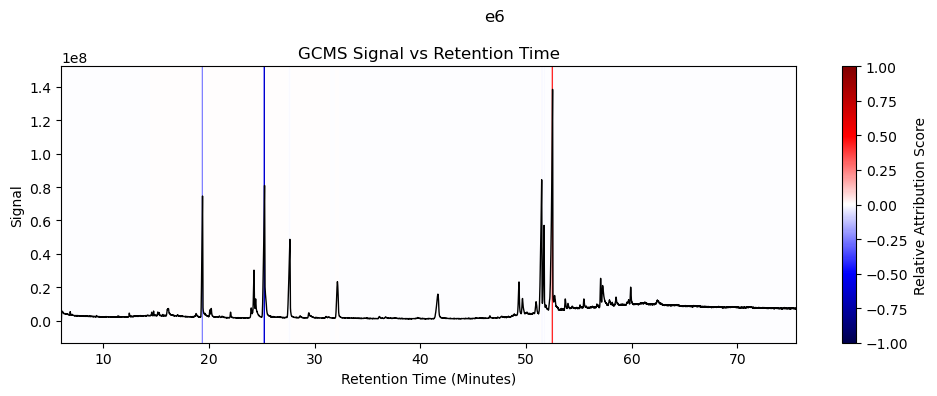

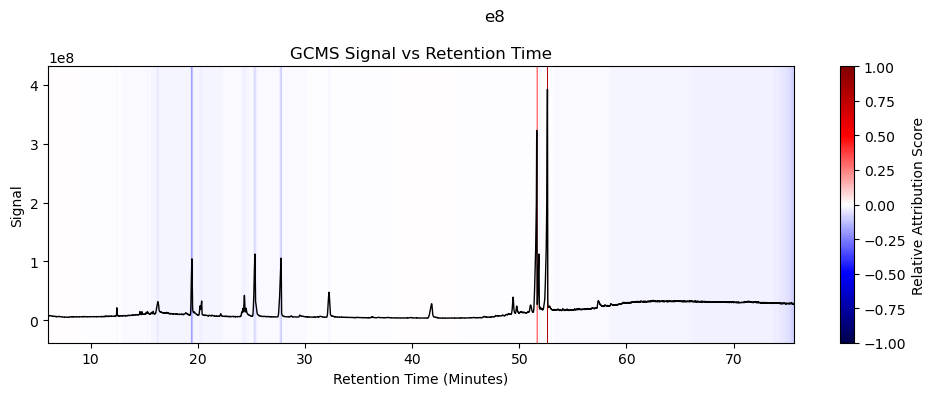

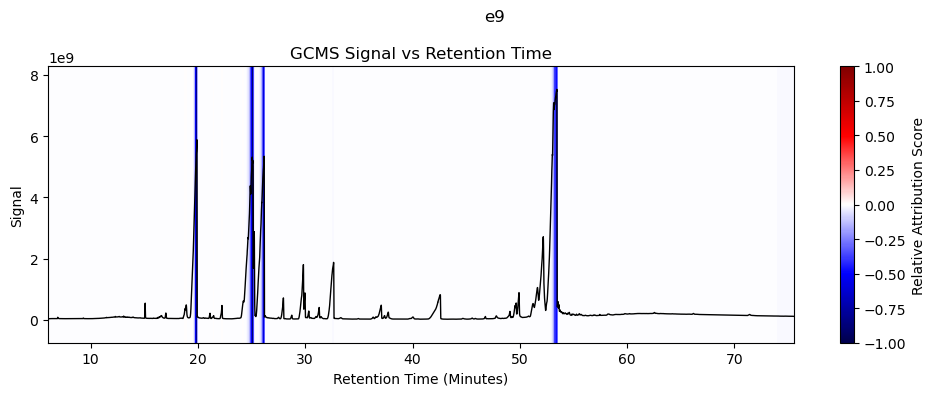

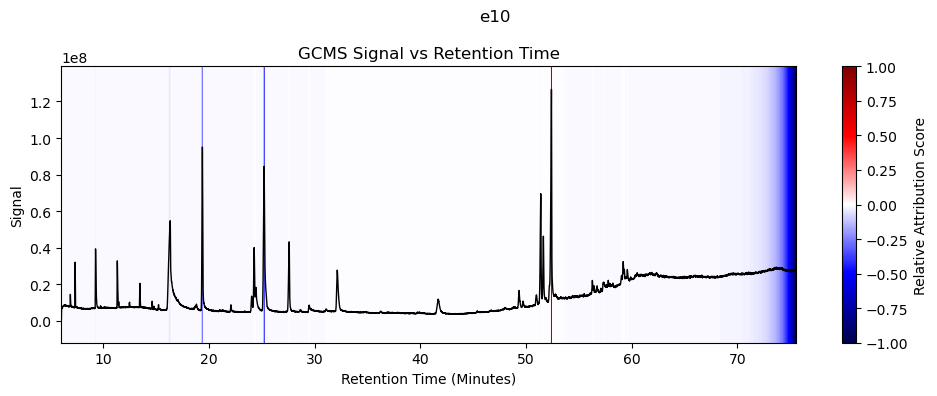

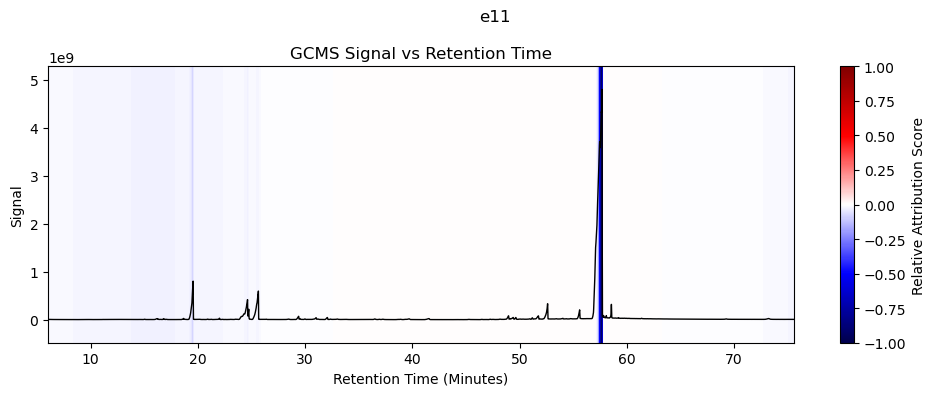

In [44]:
# sample_name = "c2"
for sample_name in sorted(sample_names, key=lambda x: (x[0], int(x[1:]))):
    score = gcms_attribution_scores[sample_name].sum(1).sum(0).sum(0)[1:].numpy()
    score /= np.max(np.abs(score))

    # score = torch.clamp(score, torch.mean(score), torch.max(score))
    # score = torch.clamp(score, 0, torch.max(score))

    rt, signal = gcms_samples[sample_name].T
    rt = rt.copy() * 60.0
    score = score[:len(rt)//gcms_encoder.patch_size]

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    plt.suptitle(sample_name)

    pad = 0.1*(np.max(signal)-np.min(signal))

    v = ax.imshow(
        score[None,:],
        extent=[rt[0], rt[-1], np.min(signal) - pad, np.max(signal) + pad],
        cmap="seismic",
        aspect="auto",
        vmin=-1.0,
        vmax=1.0)

    ax.set_title("GCMS Signal vs Retention Time")
    ax.plot(rt, signal, color="black", linewidth=1)
    ax.set_xlabel("Retention Time (Minutes)")
    ax.set_ylabel("Signal")

    plt.colorbar(v, ax=ax, cmap="seismic", label="Relative Attribution Score")

    plt.tight_layout()
    plt.savefig(f"./logs/gcms_plots/by_sample/{sample_name}.png")
    plt.show()

In [ ]:
# sample_name = "c2"
for sample_name in sorted(sample_names, key=lambda x: (x[0], int(x[1:]))):
    score = gcms_attribution_scores[sample_name].sum(1).sum(0).sum(0)[1:]
    # score = torch.clamp(score, torch.mean(score), torch.max(score))
    # score = torch.clamp(score, 0, torch.max(score))

    rt, signal = gcms_samples[sample_name].T
    score = score[:len(rt)//gcms_encoder.patch_size]

    plt.subplots(3, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1, 3]})
    plt.suptitle(sample_name)

    plt.subplot(3, 1, 1)
    plt.title("GCMS Signal vs Retention Time")
    plt.plot(rt, signal)
    plt.xlim((rt[0], rt[-1]))
    plt.ylabel("Signal")

    plt.subplot(3, 1, 2)
    # plt.title("An")
    plt.imshow(score.expand(1, -1), cmap="plasma", aspect="auto")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 1, 3)
    plt.plot(np.linspace(rt[0], rt[-1], len(score)), score)
    plt.xlim((rt[0], rt[-1]))
    plt.xlabel("Retention Time (Minutes)")
    plt.ylabel("Attribution Score")

    plt.tight_layout()
    plt.show()

In [ ]:
ps = gcms_encoder.patch_size

for sample_name in sorted(sample_names, key=lambda x: (x[0], int(x[1:]))):

    rt, signal = gcms_samples[sample_name].T
    score = gcms_attribution_scores[sample_name].sum(1).sum(0).sum(0)[1:]
    # score = score / torch.max(torch.abs(score))
    rt, signal = gcms_samples[sample_name][:len(score)*ps].T

    score = score[:len(rt)//gcms_encoder.patch_size]
    score = torch.abs(score)

    score_min, score_max = torch.min(score), torch.max(score)

    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(sample_name)
    # ax.plot(signal)
    for i in range(0, len(score)):
        color = colormaps["gnuplot2"]((1*(score[i] - score_min) / (score_max - score_min)).numpy())
        ax.plot(rt[ps*i:ps*(i+1)+1], signal[ps*i:ps*(i+1)+1], color=color, linewidth=0.8)
    # lines = colored_line(rt, signal, score, ax, linewidth=1, cmap="plasma")

    # ax.set_xlim(())
    ax.set_xlabel("Retention Time")
    ax.set_ylabel("Signal")
    fig.show()

In [26]:
n = 10000 // gcms_encoder.patch_size
low = np.inf
high = -np.inf
for sample_name in sample_names:
    rt, _ = gcms_samples[sample_name].T
    low = min(np.min(rt), low)
    high = max(np.max(rt), high)
rt_bins = np.linspace(low, high, n)
rt_bins.shape

(500,)

In [27]:
average_gcms = {"c": np.zeros_like(rt_bins), "e": np.zeros_like(rt_bins)}
counts = {"c": 0, "e": 0}
for sample_name in sorted(sample_names, key=lambda x: (x[0], int(x[1:]))):
    rt, signal = gcms_samples[sample_name].T
    indices = np.digitize(rt, rt_bins, right=True)
    for i, s in zip(indices, signal):
        average_gcms[sample_name[0]][i] += s
    counts[sample_name[0]] += 1
average_gcms["c"] = average_gcms["c"] / counts["c"]
average_gcms["e"] = average_gcms["e"] / counts["e"]

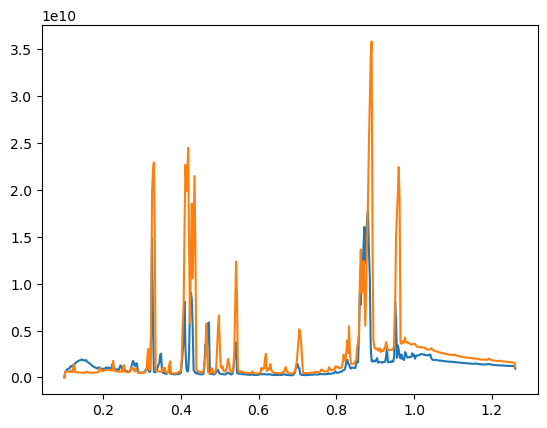

In [28]:
plt.plot(rt_bins, average_gcms["c"])
plt.plot(rt_bins, average_gcms["e"])

In [29]:
ps = gcms_encoder.patch_size
average_gcms = {"c": np.zeros_like(rt_bins), "e": np.zeros_like(rt_bins)}
counts = {"c": 0, "e": 0}
for sample_name in sorted(sample_names, key=lambda x: (x[0], int(x[1:]))):
    rt, signal = gcms_samples[sample_name].T
    score = gcms_attribution_scores[sample_name].sum(1).sum(0).sum(0)[1:]
    score = score[:len(rt)//ps]
    rt = rt[:len(rt)//ps*ps:ps]
    indices = np.digitize(rt, rt_bins, right=True)
    for i, s in zip(indices, score):
        average_gcms[sample_name[0]][i] += s
    counts[sample_name[0]] += 1
average_gcms["c"] = average_gcms["c"] / counts["c"]
average_gcms["e"] = average_gcms["e"] / counts["e"]

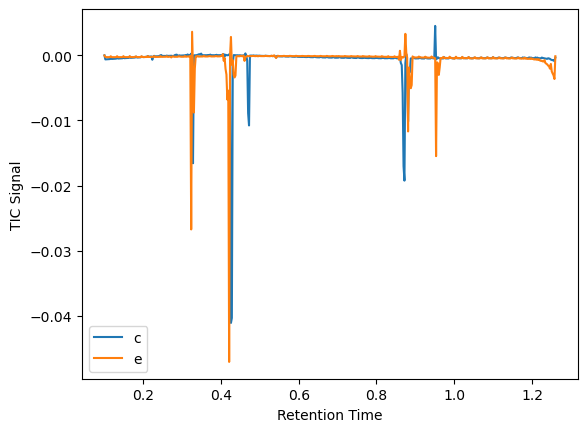

In [30]:
plt.plot(rt_bins, average_gcms["c"], label="c")
plt.plot(rt_bins, average_gcms["e"], label="e")
plt.xlabel("Retention Time")
plt.ylabel("TIC Signal")
plt.legend()

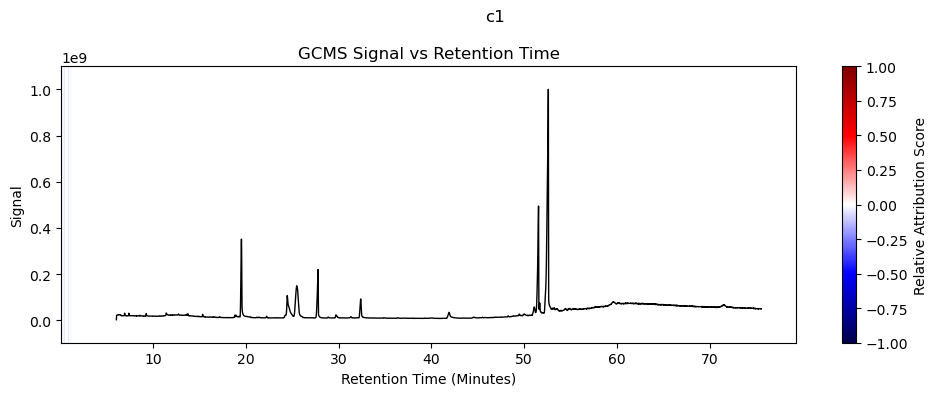

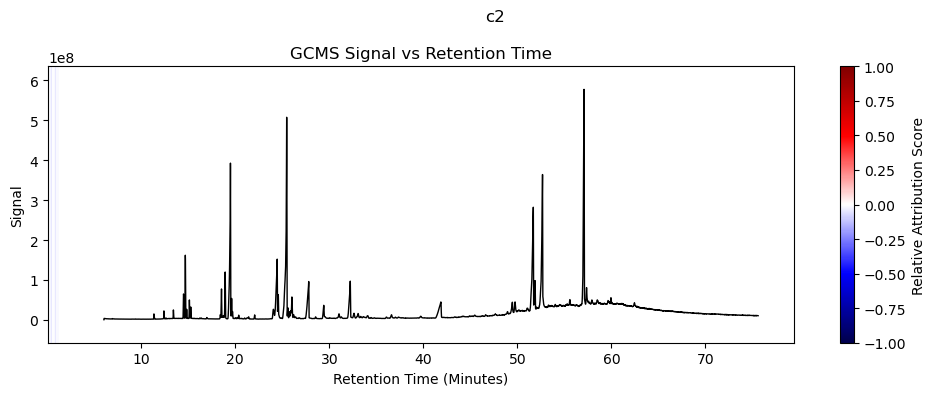

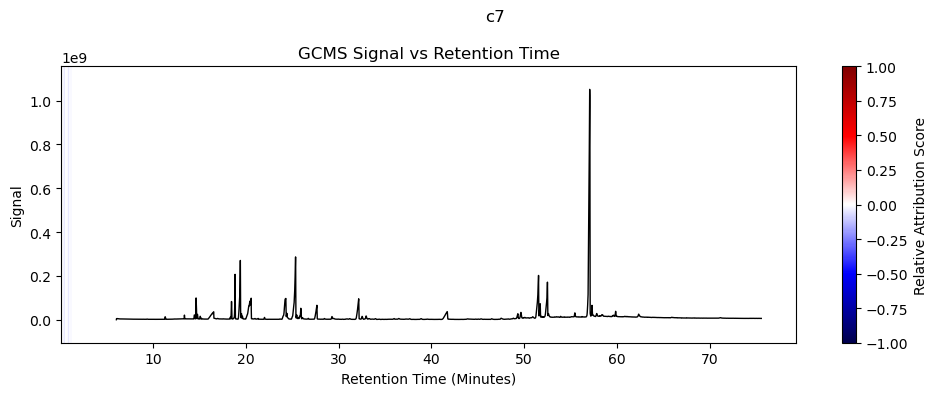

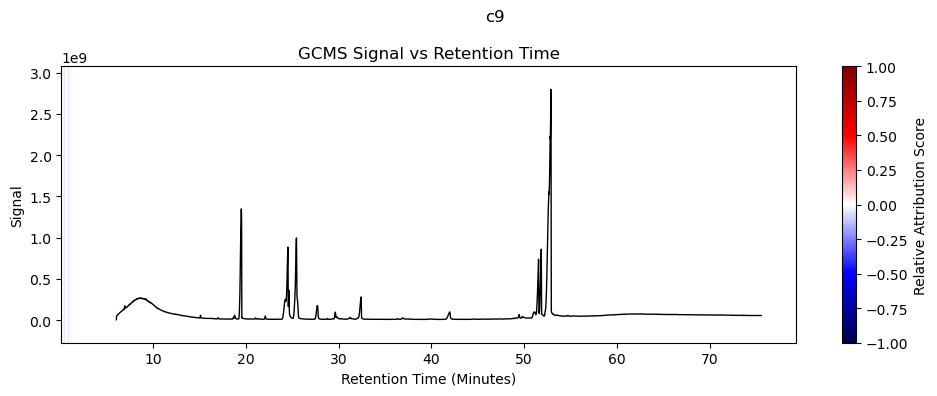

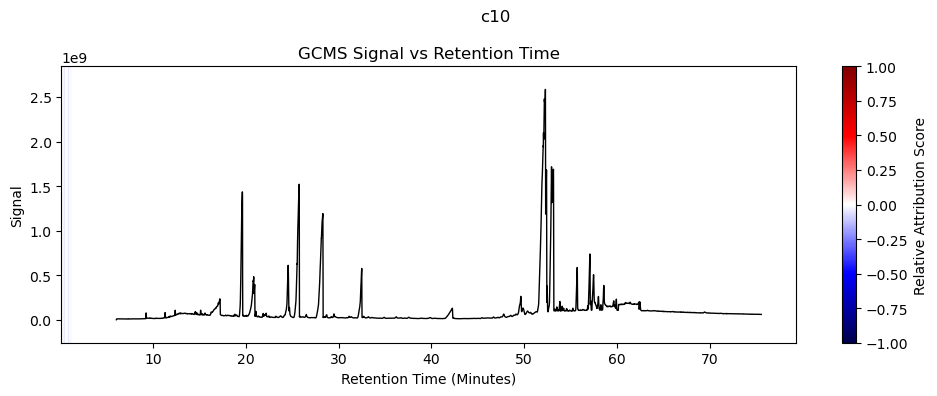

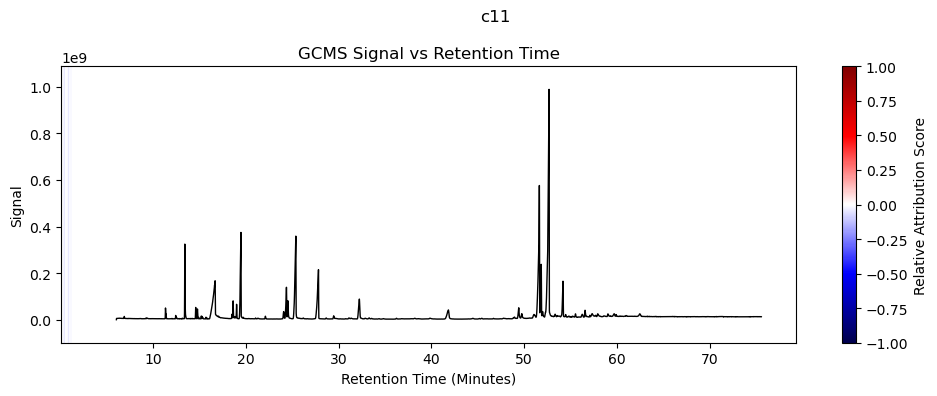

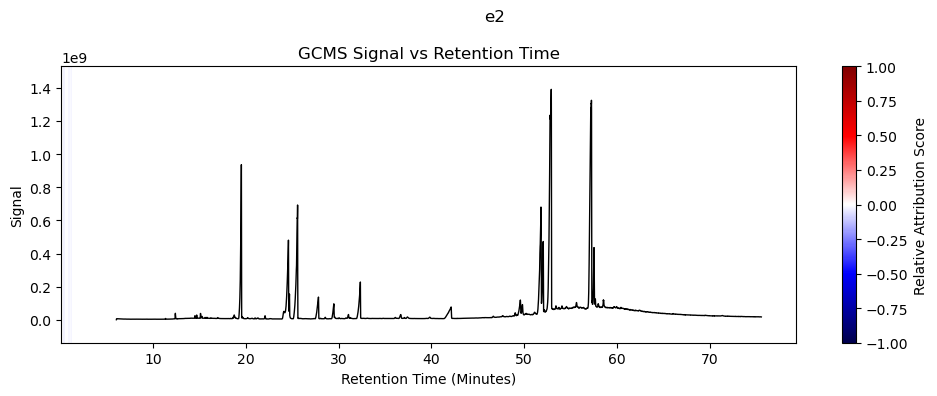

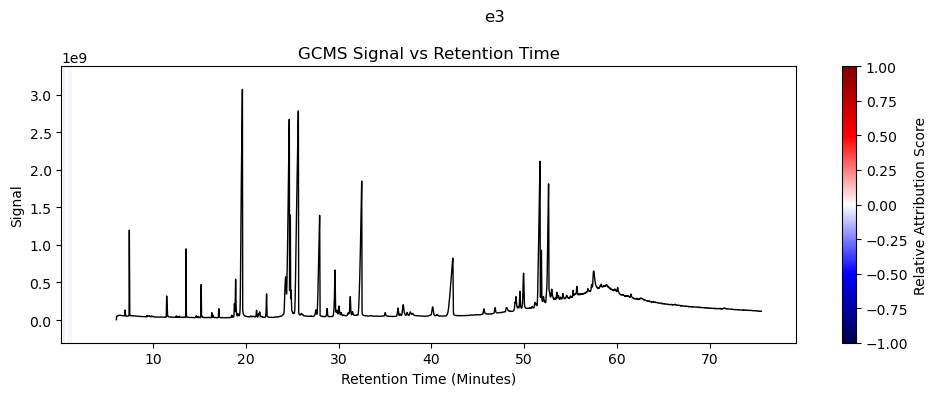

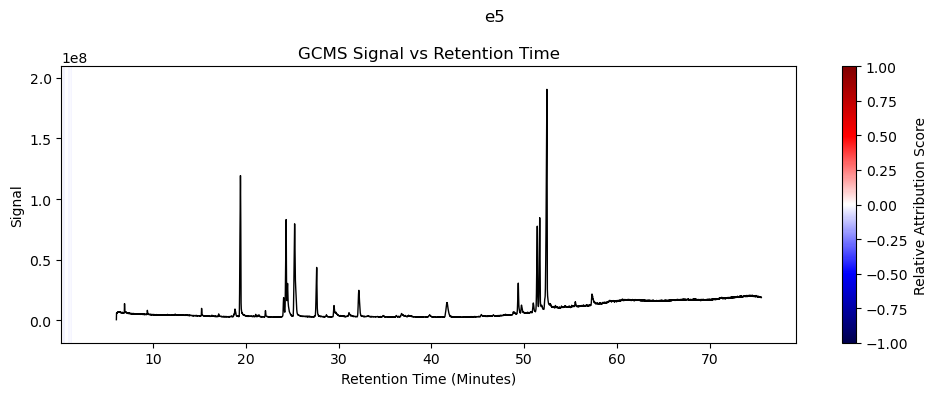

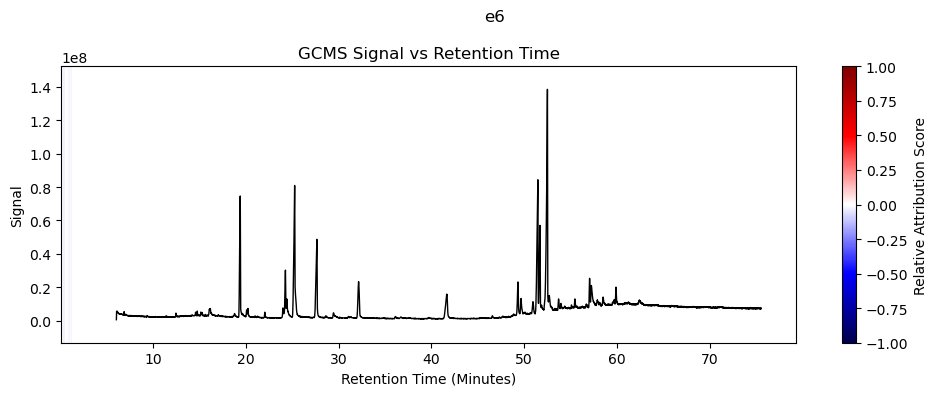

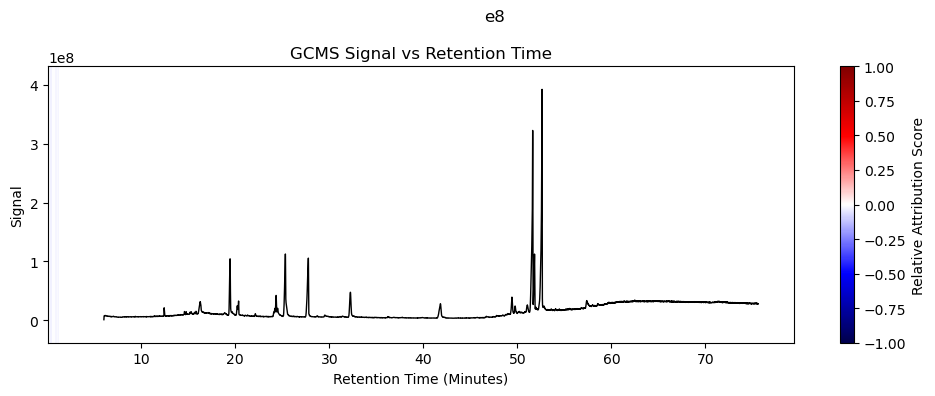

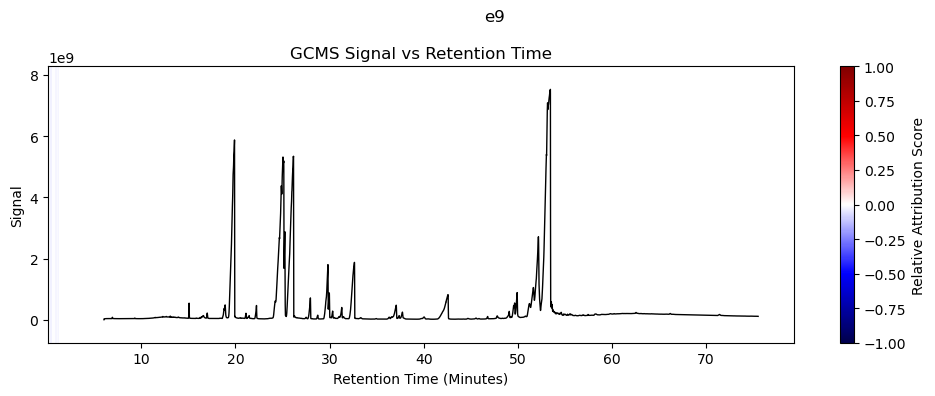

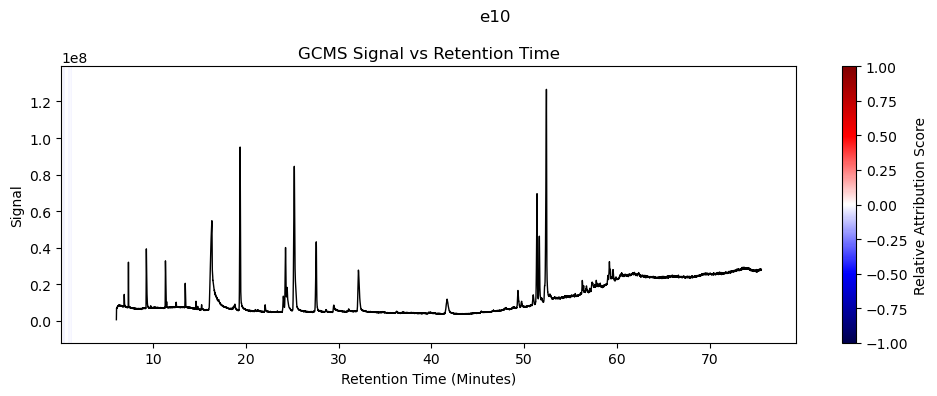

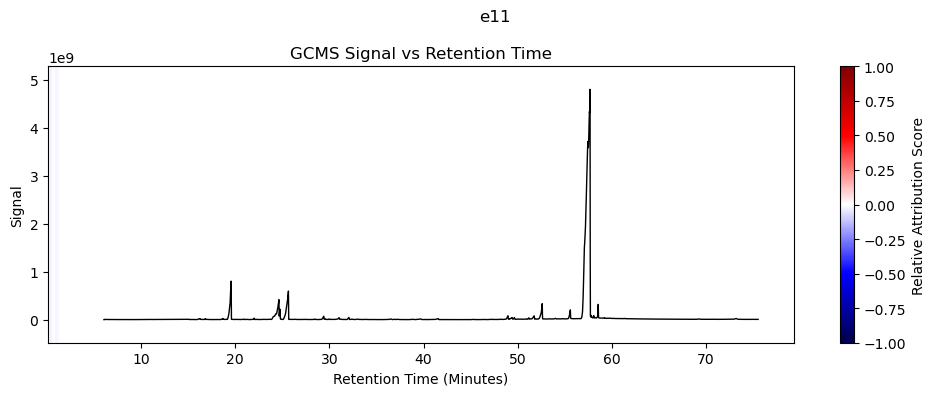

In [46]:
# sample_name = "c2"
for sample_name in sorted(sample_names, key=lambda x: (x[0], int(x[1:]))):

    score = average_gcms[sample_name[0]]
    score /= np.max(np.abs(score))
    rt, signal = gcms_samples[sample_name].T
    rt = rt.copy() * 60.0

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    plt.suptitle(sample_name)

    pad = 0.1*(np.max(signal)-np.min(signal))

    v = ax.imshow(
        score[None,:],
        extent=[rt_bins[0], rt_bins[-1], np.min(signal) - pad, np.max(signal) + pad],
        cmap="seismic",
        aspect="auto",
        vmin=-1.0,
        vmax=1.0)

    ax.set_title("GCMS Signal vs Retention Time")
    ax.plot(rt, signal, color="black", linewidth=1)
    ax.set_xlabel("Retention Time (Minutes)")
    ax.set_ylabel("Signal")

    plt.colorbar(v, ax=ax, cmap="seismic", label="Relative Attribution Score")

    plt.tight_layout()
    plt.savefig(f"./logs/gcms_plots/by_group/{sample_name}.png")
    plt.show()